In [1]:
HTML_MODE = False
if not HTML_MODE:
    %matplotlib widget
else:
    %matplotlib inline

### 週販レポート2025年版
# 標準ライブラリ
import os
from datetime import datetime, timedelta

# サードパーティライブラリ
import pandas as pd
from pandas import Timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import Markdown, display

# プロジェクト内モジュール
from gamedata import hard_sales as hs
from gamedata import plot_hard as ph
from gamedata import hard_info as hi
from gamedata import hard_event as he
from gamedata import chart_hard as ch

# レポート日付
from report_config import get_config

config = get_config()
report_date = config["date"]

def show_title(d:datetime) -> None:
    last_updated_str = d.strftime("%Y-%m-%d")
    mode = "[[LAB MODE]]" if not HTML_MODE else ""
    display(Markdown(f"# 国内ゲームハード週販レポート ({last_updated_str}) {mode}"))

show_title(report_date)

if not HTML_MODE:
    plt.show()

# 国内ゲームハード週販レポート (2025-09-07) [[LAB MODE]]

* ハードウェアの販売データはファミ通の調査結果を元にしています。
* 一部のデータについては処理の都合上、1週間毎の値にアレンジしています。

## 直近4週間のハード売り上げ／累計推移


PS5がオータムセールで急伸、3万台を超えて一気に累計700万台を突破しました。おめでとうございます。
PS5がSwitchの週販を超えるのはDays of Playセールの6月8日以来、約3ヶ月ぶりです。
9/10にPS4版 原神の新規DLが停止されたので、PS4からPS5への原神移行需要の影響も考えられます。
次回集計にもオータムセールの効果は含まれるので、PS5がどこまで伸ばすか注目です。

Switch2の供給は今週もタイトです。
9/12のNintendo Direct配信で購買意欲を煽るだけ煽ってモノが無いというのは得策では無いので、
今週末には多めの出荷があると期待したいですね。
Switch2 200万台まで2万台弱。次回集計で200万台突破は確実です。

In [4]:
def chart_4weeks() -> None:
    df1 = hs.load_hard_sales()
    # 4 weeks before
    before_4weeks = hs.current_report_date(df1) - Timedelta(weeks=4-1)
    (out1, style1) = ch.chart_units_by_date_hw(df1, begin=before_4weeks)
    display(style1)
    
chart_4weeks()

## 2025年の週販推移

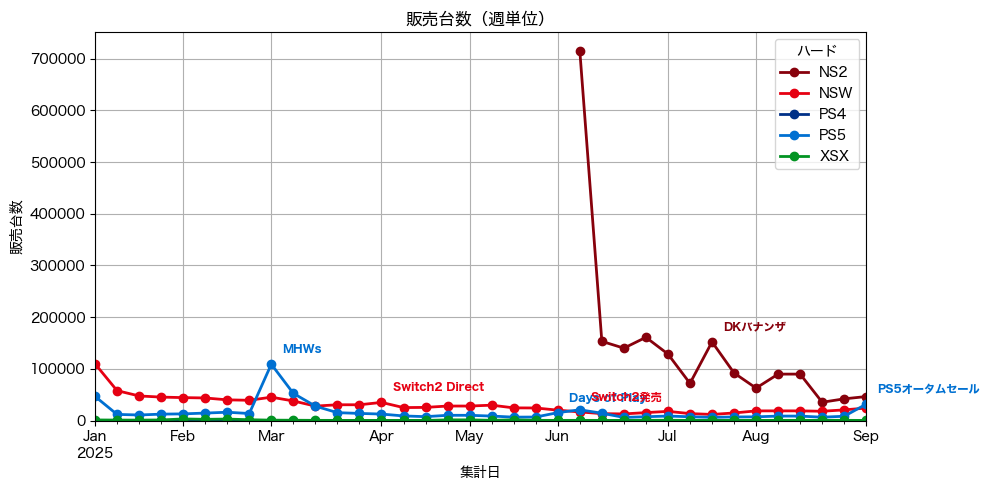

In [5]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), event_flag=True, event_priority=1.5)

### 2025年の週販推移(Switch2以外を拡大）

PS5のセール効果が顕著です。効果があり過ぎて、セール期間以外は売れない商品と化している気がしないでもありません。

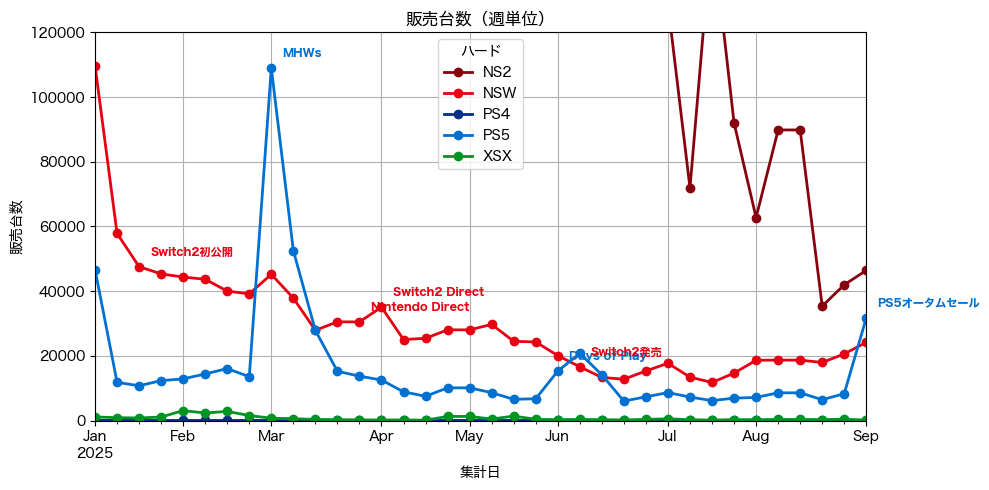

In [6]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), ymax=120000, event_flag=True, event_priority=3)

## PS5 700万台達成

PS5の700万台達成は251週目です。
PS4の237週から14週遅れてますが、PS3よりは9週早い。
PS3以降の据え置きPSとして同水準の普及スピードです。

これを見ると100週で700万台というのが「成功ハード」の水準かもしれません。

In [7]:
hard_sales_df= hs.load_hard_sales()
df = hs.extract_week_reached_units(hard_sales_df, threshold_units=7000000)
df = df[['full_name', 'report_date', 'delta_week','sum_units']]
df = df.sort_values(by=['delta_week'])
df.columns = ['ハード', '達成年週', '週数', '累計販売数']
df.set_index(['ハード'], inplace=True)
display(df)

,達成年週,週数,累計販売数
ハード,,,
Nintendo DS,2006-04-16,71,7142963
Nintendo 3DS,2012-08-12,76,7022396
GAME BOY ADVANCE,2002-12-15,90,7010702
Nintendo Switch,2019-01-06,96,7115244
PlayStation2,2002-02-03,100,7020883
Wii,2008-11-23,103,7024239
PlayStation Portable,2007-12-09,156,7057453
PlayStation4,2018-09-09,237,7001086
PlayStation5,2025-09-07,251,7009937


PS3, PS4, PS5の250週前後の累計グラフです。PS5がPS4と同じ軌跡を目指すかのようにオータムセールによる上昇を見せています。
ただ、オータムセール効果は次回集計まで、それ以後は反動による落ち込みが予想されます。
残念ながら大バンバンラインには届かず、PS4から70万台少ない水準でしばらくは推移しそうです。
今後の状況によってはPS3を下回る可能性もありますが、それだけはSIEが必死に策を弄して回避を試みそうな予感もします。

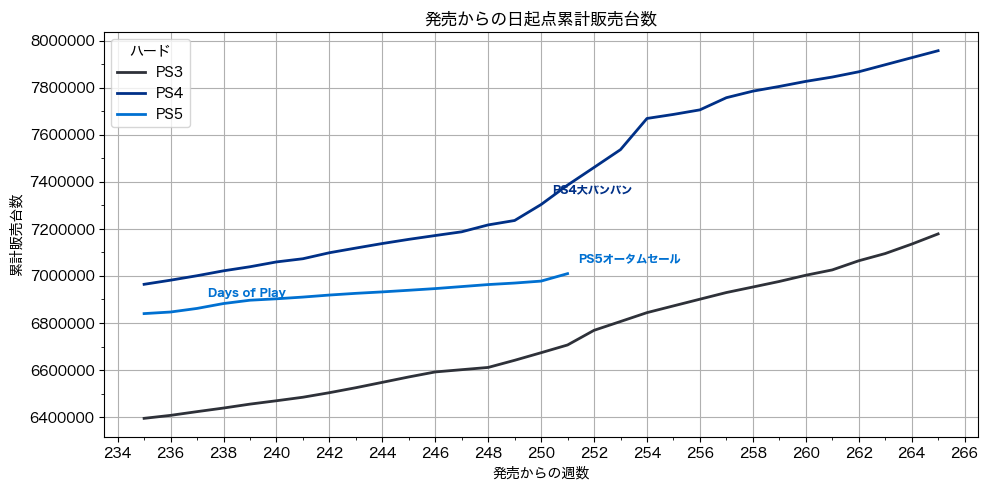

In [8]:
(fig, df) = ph.plot_cumulative_sales_by_delta(hw=['PS4', 'PS5', 'PS3'], xgrid=2, ygrid=200000,begin=235, end=265, event_priority=5)

## 2025年月間販売推移

2025年の各月の販売台数です。6月のSwitch2のおかげで他の機種の状態が分かりにくですね。

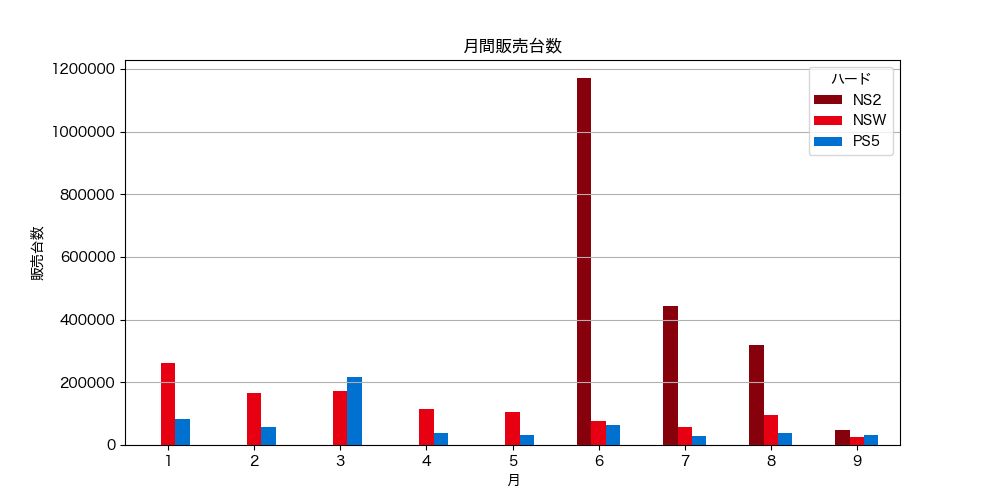

In [3]:
(fig, df) = ph.plot_monthly_bar_by_hard(hw=["NS2", "PS5", "NSW"], year=2025)

In [35]:
df = df.format({'NS2': '{:,.0f}', 'NSW': '{:,.0f}', 'PS5': '{:,.0f}'})
display(df)

hw,NS2,NSW,PS5
month,,,
1,0,"260,447","81,587"
2,0,"167,188","56,886"
3,0,"171,921","218,300"
4,0,"113,513","38,983"
5,0,"106,506","32,001"
6,"1,169,684","78,097","63,516"
7,"444,706","57,532","28,959"
8,"319,690","94,517","39,004"
9,"46,403","24,175","31,695"


### Nintendo Switchの月間販売台数： 2023,2024年との比較

4月のSwitch2発表以降の前年比の落ち込みが大きい状況。
今後のSwitchの年末商戦は全く読めません。
Switch出荷するくらいなら、Switch2全力を期待したいところです。

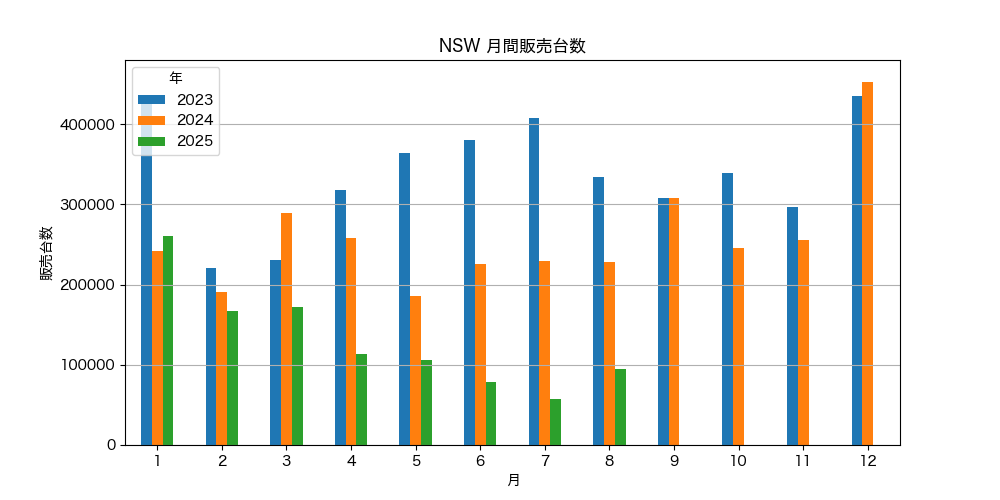

In [4]:
(fig, df) = ph.plot_monthly_bar_by_year(hw="NSW", ymax=480000, begin=datetime(2023,1,1), end=datetime(2025,8,31))

### PlayStation 5の月間販売台数： 2023, 2024年との比較

MHWs効果が出た3月以外は昨年に比べて大きく落ち込んでいます。
それでも3月のPS5新生活セールとMHWs効果、6月のDays of Playのセール期間は盛り返しています。
9月4日に始まったオータムセールは効果絶大なので9月は前年比50%を超えるのを期待したいですね。

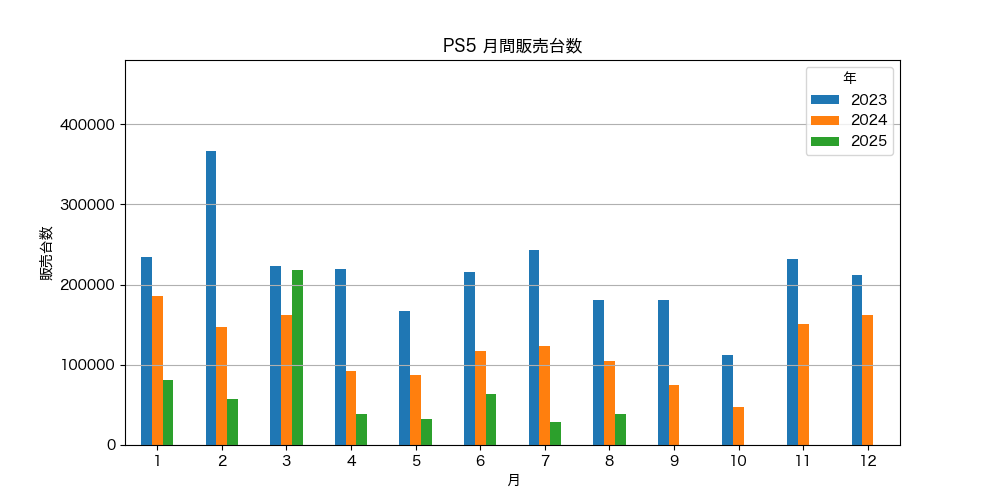

In [4]:
(fig, df) = ph.plot_monthly_bar_by_year(hw="PS5", ymax=480000, begin=datetime(2023,1,1), end=datetime(2025,8,31))

## 累計販売推移

累計については、しばらく状況変化無いでしょう。Switch2がPS5を超えるのも1年以上先でしょうし。ところでPS4はいつまで集計続けるんでしょうか。

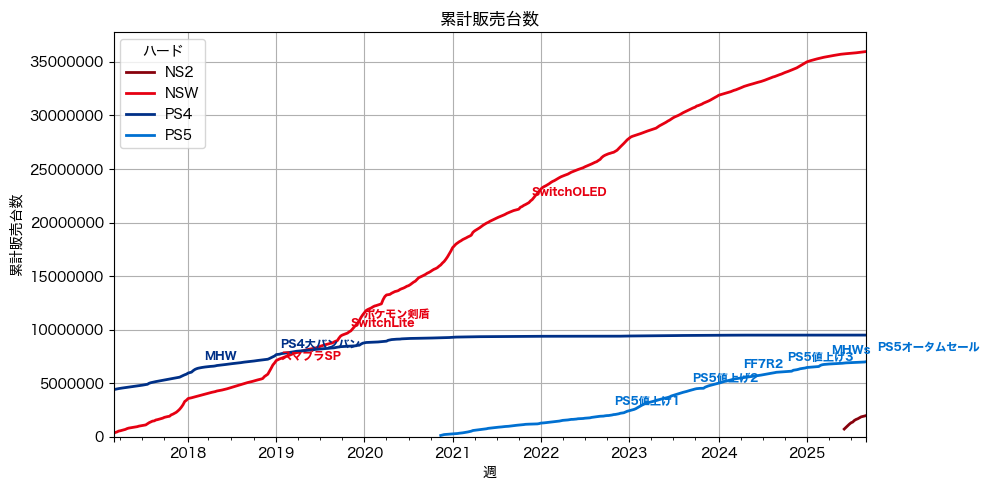

In [12]:
(fig, df) = ph.plot_cumulative_sales(hw=['PS4', 'NS2', 'PS5', 'NSW'], begin=datetime(2017,3,1), event_flag=True, event_priority=0.5)


## Switch2販売状況

### 歴代機種との比較

Switch2はGBAに次ぐ歴代2位の初動を維持していますが、出荷制限の影響が続いています。

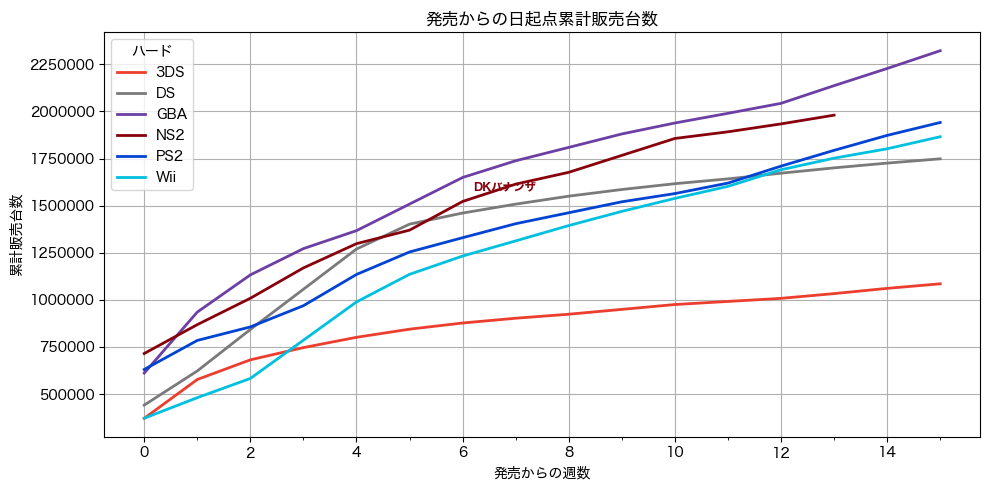

In [13]:
(fig, df) = ph.plot_cumulative_sales_by_delta(hw=["GBA", "NS2", "DS", "PS2", "Wii", "3DS"], 
                                        mode="week", xgrid=2, end=15)

In [14]:
df12 = df.iloc[df.index == 13]
# df12をunpivotして、列名を"ハード"、"販売数"にする
df12_unpivot = df12.unstack().reset_index()
df12_unpivot.columns = ['ハード', '週数', '販売数']
df12_unpivot.sort_values(by='販売数', ascending=False, inplace=True)
df12_unpivot.set_index('ハード', inplace=True)
display(df12_unpivot.style.format({'販売数': '{:,.0f}'}))

,週数,販売数
ハード,,
GBA,13,"2,137,065"
NS2,13,"1,980,483"
PS2,13,"1,793,715"
Wii,13,"1,752,238"
DS,13,"1,700,752"
3DS,13,"1,033,333"


## Switch/Switch2ロンチ比較

ロンチ週以降のSwitchとSwitch2の販売状況(実質的に出荷状況)の比較です。
Switch2が大量出荷される段階は終わり、Switchと似た推移を辿っています。
Nintendo Direct直後の第14週集計に厚い出荷があることを期待しましょう。

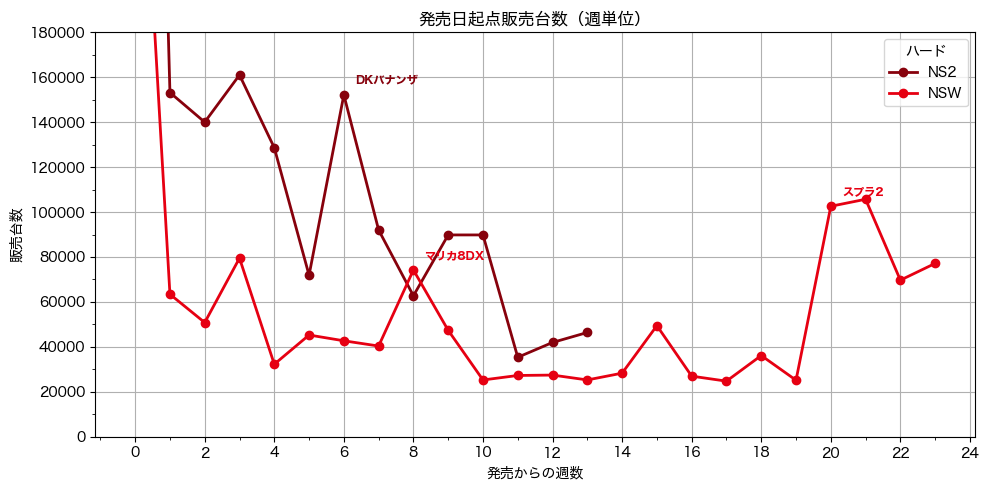

In [15]:
(fig, df) = ph.plot_sales_by_delta(hw=["NSW", "NS2"], end=23, ymax=180000, xgrid=2, ygrid=20000, mode="week", event_flag=True, event_priority=3)


## 年単位の状況

(2025年については8月までの状況です)

Switchが健闘しています。最終的に150万台に到達するかも(それでも昨年比で半減ですが)。
なぜかPS5も落ち込んでいます。年内100万台は難しそうです。

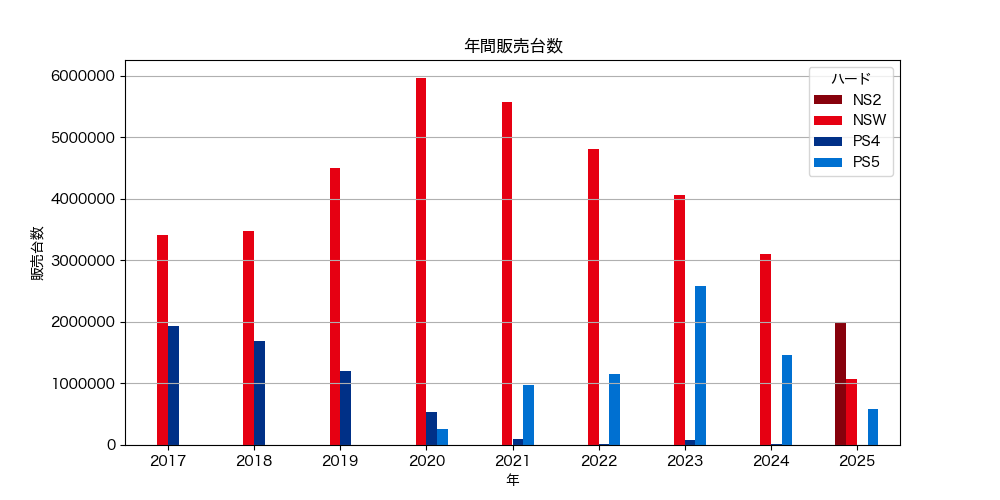

In [5]:
(fig, df) = ph.plot_yearly_bar_by_hard(hw=['PS4', 'PS5', 'NSW', 'NS2'], begin=datetime(2017,1,1), end=datetime(2025,12,31))

Switch2の販売台数の延びにより、任天堂が2025年に記録的シェアを達成する可能性が高まっています。

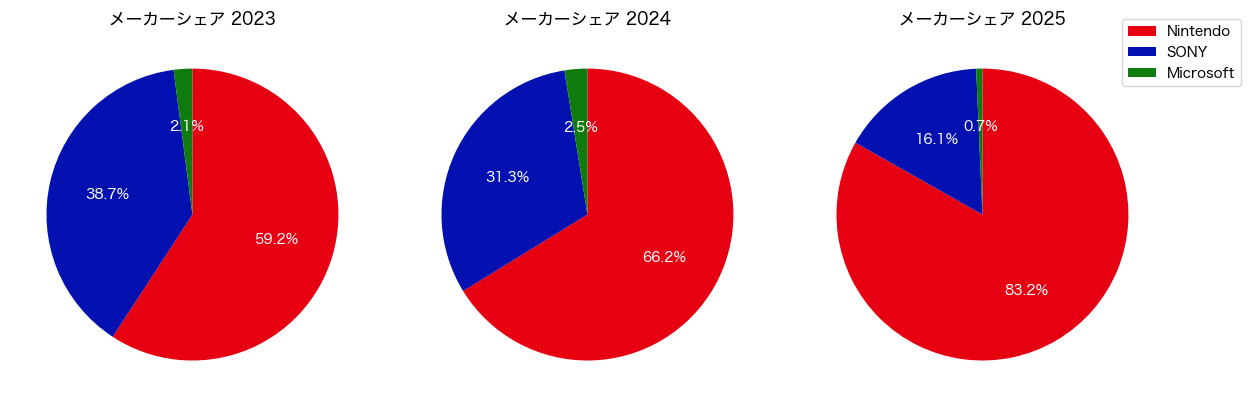

In [17]:
(fig, df) = ph.plot_maker_share_pie(begin_year=2023, end_year=2025)